This notebook implements statistical downscaling of precipitation using the Mixed Bernoulli-Gamma model to synthetic data. It includes:

- Fitting the Mixed Bernoulli-Gamma model to observed and climate model data.
- Bias correction for probability and intensity distributions.
- Generating high-resolution downscaled precipitation while preserving total rainfall.

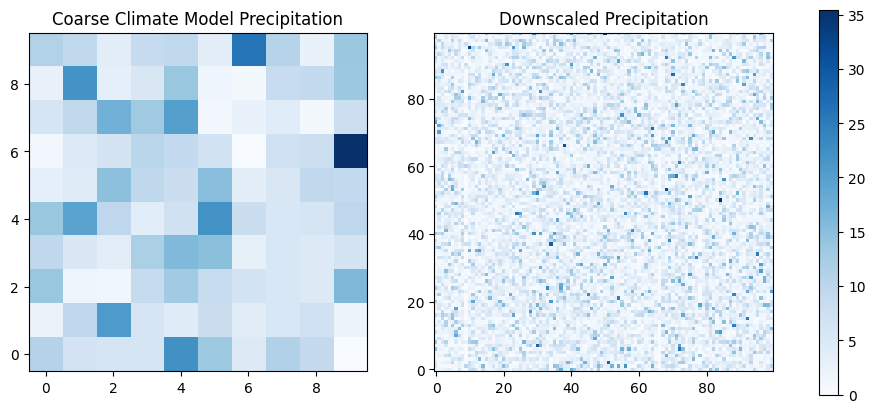

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def fit_bernoulli_gamma(precip_data):
    """
    Fit a Mixed Bernoulli-Gamma model to precipitation data.
    
    The model consists of two components:
    1. A Bernoulli distribution for the probability of precipitation (p).
    2. A Gamma distribution for the rainfall intensity (if precipitation occurs).

    Parameters:
    - precip_data: Array of precipitation values (e.g., rainfall amounts).

    Returns:
    - p: Probability of precipitation (Bernoulli component).
    - shape: Shape parameter of the Gamma distribution (if precipitation occurs).
    - scale: Scale parameter of the Gamma distribution (if precipitation occurs).
    """
    p = np.mean(precip_data > 0)  # Probability of precipitation (fraction of non-zero values)
    if p > 0:
        rain_values = precip_data[precip_data > 0]  # Extract only non-zero precipitation values
        shape, loc, scale = stats.gamma.fit(rain_values, floc=0)  # Fit Gamma distribution to rain values
    else:
        shape, loc, scale = 0, 0  # If no precipitation, set shape and scale to 0
    return p, shape, loc, scale

def bias_correction(p_obs, shape_obs, scale_obs, p_climate, shape_climate, scale_climate):
    """
    Compute bias correction factors between observed and climate model precipitation.

    Bias correction adjusts for differences in the probability and intensity of precipitation
    between the observed data and the climate model data.

    Parameters:
    - p_obs: Probability of precipitation from the observed data.
    - shape_obs: Shape parameter of the Gamma distribution for the observed data.
    - scale_obs: Scale parameter of the Gamma distribution for the observed data.
    - p_climate: Probability of precipitation from the climate model data.
    - shape_climate: Shape parameter of the Gamma distribution for the climate model data.
    - scale_climate: Scale parameter of the Gamma distribution for the climate model data.

    Returns:
    - p_bias: Bias correction factor for the probability of precipitation.
    - shape_bias: Bias correction factor for the shape parameter of the Gamma distribution.
    - scale_bias: Bias correction factor for the scale parameter of the Gamma distribution.
    """
    p_bias = np.clip(p_obs / p_climate, 0, 2) if p_climate > 0 else 1  # Adjust probability of precipitation
    shape_bias = np.clip(shape_obs / shape_climate, 0.5, 2) if shape_climate > 0 else 1  # Adjust Gamma shape
    scale_bias = np.clip(scale_obs / scale_climate, 0.5, 2) if scale_climate > 0 else 1  # Adjust Gamma scale
    return p_bias, shape_bias, scale_bias

def downscale_precipitation(coarse_precip, p_bias, shape_bias, scale_bias, fine_grid_shape):
    """
    Generate downscaled precipitation using the Mixed Bernoulli-Gamma model.

    The model downscales coarse precipitation data to a finer grid by adjusting the
    probability of precipitation and intensity based on bias correction factors.

    Parameters:
    - coarse_precip: Coarse-resolution precipitation data from the climate model.
    - p_bias: Bias correction factor for the probability of precipitation.
    - shape_bias: Bias correction factor for the shape parameter of the Gamma distribution.
    - scale_bias: Bias correction factor for the scale parameter of the Gamma distribution.
    - fine_grid_shape: Shape of the fine-resolution grid to which the precipitation will be downscaled.

    Returns:
    - rain_intensity: Downscaled precipitation intensity for the fine grid.
    """
    # Resize coarse precipitation to match the fine grid shape
    coarse_precip_resized = np.resize(coarse_precip, fine_grid_shape)
    
    fine_p = np.clip(coarse_precip_resized * p_bias, 0, 1)  # Adjusted probability of precipitation
    rain_occurrence = np.random.rand(*fine_grid_shape) < fine_p  # Simulate whether it rains in each grid cell
    
    rain_intensity = np.zeros(fine_grid_shape)  # Initialize array for rain intensity
    rain_intensity[rain_occurrence] = stats.gamma.rvs(
        shape_bias, scale=scale_bias, size=np.sum(rain_occurrence)
    )  # Generate rain intensity from Gamma distribution for rainy cells
    
    # Mass balance adjustment: scale intensity to match the total precipitation
    coarse_total = np.sum(coarse_precip_resized)  # Total precipitation in the coarse grid
    fine_total = np.sum(rain_intensity)  # Total precipitation in the fine grid
    if fine_total > 0:
        rain_intensity *= (coarse_total / fine_total)  # Adjust intensity to match total precipitation
    
    return rain_intensity

def plot_precipitation(coarse_precip, downscaled_precip):
    """
    Plot coarse and downscaled precipitation side by side for comparison.

    Parameters:
    - coarse_precip: Coarse-resolution precipitation data from the climate model.
    - downscaled_precip: Downscaled precipitation data from the Mixed Bernoulli-Gamma model.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots
    
    axes[0].imshow(coarse_precip, cmap='Blues', origin='lower')  # Display coarse precipitation
    axes[0].set_title("Coarse Climate Model Precipitation")
    
    axes[1].imshow(downscaled_precip, cmap='Blues', origin='lower')  # Display downscaled precipitation
    axes[1].set_title("Downscaled Precipitation")
    
    plt.colorbar(axes[1].imshow(downscaled_precip, cmap='Blues', origin='lower'), ax=axes)  # Add colorbar
    plt.show()  # Show the plots

# Example usage:
np.random.seed(42)  # Set random seed for reproducibility
coarse_precip = np.random.gamma(2, 2, size=(10, 10))  # Simulated coarse precipitation data
obs_precip = np.random.gamma(2.5, 1.5, size=(100, 100))  # Simulated observed precipitation data

# Fit Mixed Bernoulli-Gamma model to observed and climate model precipitation
p_obs, shape_obs, loc_climate, scale_obs = fit_bernoulli_gamma(obs_precip.flatten())
p_climate, shape_climate, loc_climate, scale_climate = fit_bernoulli_gamma(coarse_precip.flatten())

# Compute bias correction factors between observed and climate model data
p_bias, shape_bias, scale_bias = bias_correction(p_obs, shape_obs, scale_obs, p_climate, shape_climate, scale_climate)

# Downscale precipitation from coarse grid to fine grid
fine_grid_shape = (100, 100)  # Desired shape for the fine-resolution grid
downscaled_precip = downscale_precipitation(coarse_precip, p_bias, shape_bias, scale_bias, fine_grid_shape)

# Plot the results for comparison
plot_precipitation(coarse_precip, downscaled_precip)
